-------------load the model-----------------
Train on 1310 samples, validate on 500 samples
Epoch 1/40
1310/1310 [==============================] - 3s 2ms/sample - loss: 0.6375 - sparse_categorical_accuracy: 0.6313 - val_loss: 0.5804 - val_sparse_categorical_accuracy: 0.6260
Epoch 2/40
1310/1310 [==============================] - 2s 2ms/sample - loss: 0.5335 - sparse_categorical_accuracy: 0.7511 - val_loss: 0.4947 - val_sparse_categorical_accuracy: 0.7880
Epoch 3/40
1310/1310 [==============================] - 2s 2ms/sample - loss: 0.4477 - sparse_categorical_accuracy: 0.8191 - val_loss: 0.3978 - val_sparse_categorical_accuracy: 0.8520
Epoch 4/40
1310/1310 [==============================] - 2s 2ms/sample - loss: 0.3996 - sparse_categorical_accuracy: 0.8244 - val_loss: 0.3956 - val_sparse_categorical_accuracy: 0.8360
Epoch 5/40
1310/1310 [==============================] - 2s 2ms/sample - loss: 0.3745 - sparse_categorical_accuracy: 0.8313 - val_loss: 0.3353 - val_sparse_categorical_accur

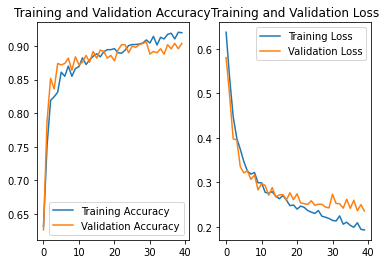

In [12]:
import tensorflow as tf
from PIL import Image
import numpy as np
import os
from matplotlib import pyplot as plt
from tensorflow.keras.layers import Conv2D, BatchNormalization, Activation, MaxPool2D, Dropout, Flatten, Dense
from tensorflow.keras import Model
import json

train_path = 'melon6/total/'
train_txt = 'melon6/train.txt'
test_path = 'melon6/total/'
test_txt = 'melon6/test.txt'

def generateds(path, txt):
    f = open(txt, 'r')  # 以只读形式打开txt文件
    contents = f.readlines()  # 读取文件中所有行
    f.close()  # 关闭txt文件
    x, y_ = [], []  # 建立空列表
    for content in contents:  # 逐行取出
        value = content.split()  # 以空格分开，图片路径为value[0] , 标签为value[1] , 存入列表
        img_path = path + value[0]  # 拼出图片路径和文件名
#         print(img_path)
        img = Image.open(img_path)  # 读入图片
        img = np.array(img.convert('RGB'))  # 图片变为8位宽灰度值的np.array格式
#         img = np.array(img.convert('L'))  # 图片变为8位宽灰度值的np.array格式
        img = img / 255.  # 数据归一化 （实现预处理）
#         print(img)
        x.append(img)  # 归一化后的数据，贴到列表x
        y_.append(value[1])  # 标签贴到列表y_
#         print('loading : ' + content)  # 打印状态提示

    x = np.array(x)  # 变为np.array格式
    y_ = np.array(y_)  # 变为np.array格式
    y_ = y_.astype(np.int64)  # 变为64位整型
    return x, y_  # 返回输入特征x，返回标签y_



x_train, y_train = generateds(train_path, train_txt)
x_test, y_test = generateds(test_path, test_txt)

    
##################网络结构##################
model = tf.keras.models.Sequential([
    tf.keras.layers.Conv2D(32, (3, 3),padding='SAME', activation='relu', input_shape=(32, 32, 3)),
    tf.keras.layers.MaxPooling2D(2, 2),
    tf.keras.layers.Conv2D(32, (3, 3), padding='SAME', activation='relu'),
    tf.keras.layers.MaxPooling2D(2, 2),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(128, activation=tf.nn.relu),
    tf.keras.layers.Dense(2, activation=tf.nn.softmax)
])


model.compile(optimizer=tf.keras.optimizers.Adam(0.0001),
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False),
              metrics=['sparse_categorical_accuracy'])

checkpoint_save_path = "checkpoint/CNN.ckpt"

if os.path.exists(checkpoint_save_path + '.index'):
    print('-------------load the model-----------------')
#     model.load_weights(checkpoint_save_path)

cp_callback = tf.keras.callbacks.ModelCheckpoint(filepath=checkpoint_save_path,
                                                 save_weights_only=True,
                                                 save_best_only=True)


history = model.fit(x_train, y_train, batch_size=32, epochs=40, validation_data=(x_test, y_test)
                    , validation_freq=1,callbacks=[cp_callback]
                   )

model.summary()


# print(model.trainable_variables)
file = open('CNNweights.txt', 'w')
for v in model.trainable_variables:
    file.write(str(v.name) + '\n')
    file.write(str(v.shape) + '\n')
    file.write(str(v.numpy()) + '\n')
file.close()

model.save('CNN.h5')
print("save")

###############################################    show   ###############################################

# 显示训练集和验证集的acc和loss曲线
acc = history.history['sparse_categorical_accuracy']
val_acc = history.history['val_sparse_categorical_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']

plt.subplot(1, 2, 1)
plt.plot(acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.title('Training and Validation Accuracy')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.title('Training and Validation Loss')
plt.legend()
plt.show()
